In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin # Inheriting from base classes
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import contextily as ctx

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/california-housing-prices/housing.csv


In [2]:
housing = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")
housing.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All are numerical attributes except ocean_proximity, which is a categorical variable. Let's look at all its categories using value_counts()

In [4]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

(3, 3)


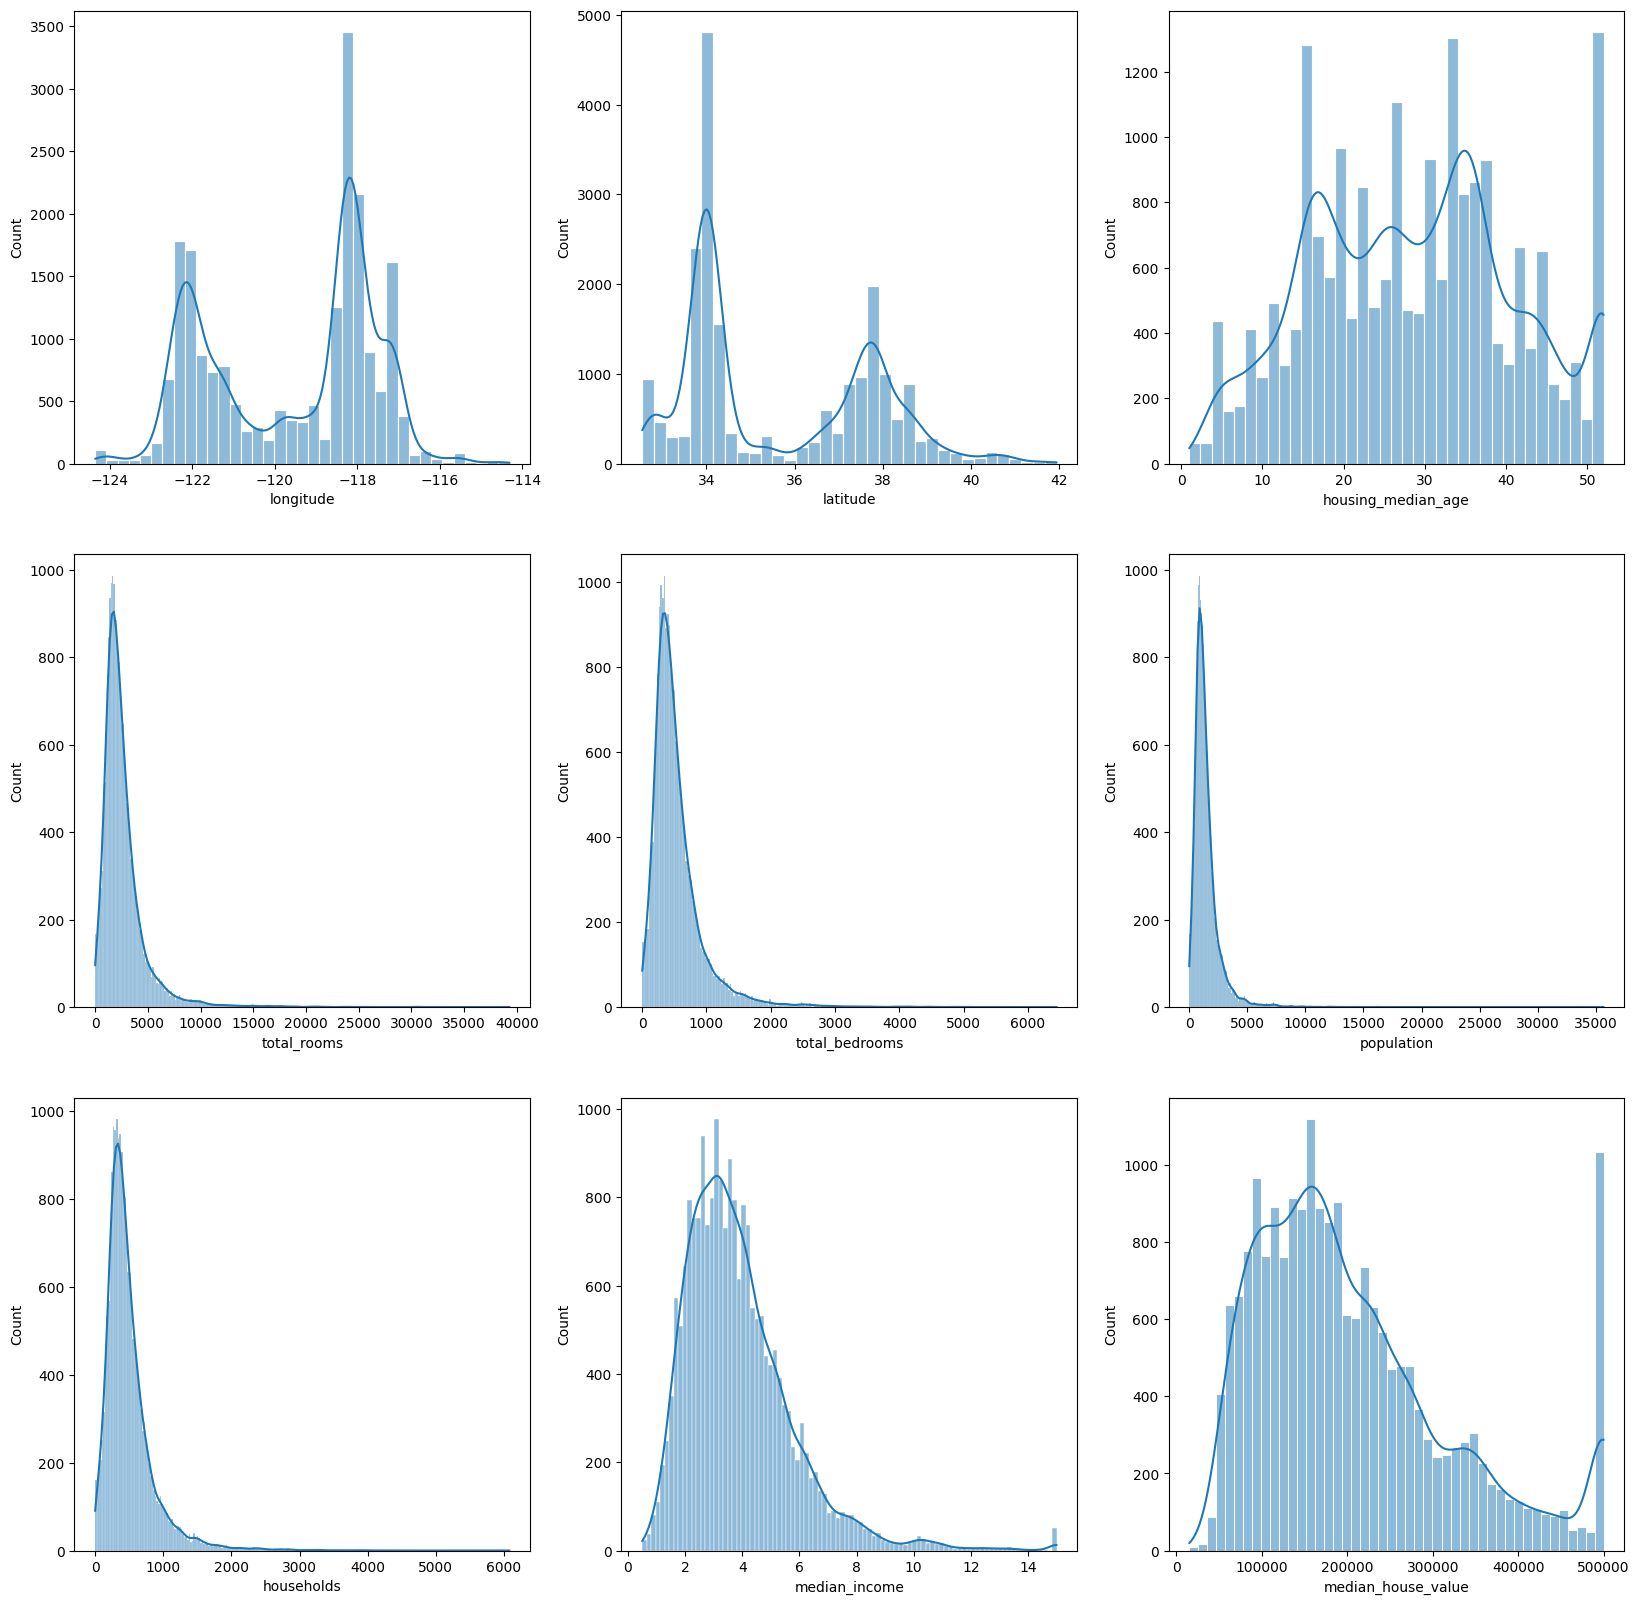

In [5]:
figure, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
print(axs.shape)
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
axs = axs.flatten()
for i, col in enumerate(housing.select_dtypes(include='number').columns):
    sns.histplot(housing[col], fill=True, kde=True, ax=axs[i])
plt.show()

Let's calculate mean housing price for ocean proximity

In [6]:
housing.groupby(['ocean_proximity'])[['median_house_value','median_income']].mean()

median_house_value  median_income
ocean_proximity                                   
<1H OCEAN             240084.285464       4.230682
INLAND                124805.392001       3.208996
ISLAND                380440.000000       2.744420
NEAR BAY              259212.311790       4.172885
NEAR OCEAN            249433.977427       4.005785

It seems strange how the households on Island have the higher value properties but their incomes are lowest. Maybe we don't have enough data to conclude as there are only 5 districts with Island category.

In [7]:
housing[housing['ocean_proximity']=='ISLAND']

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8314    -118.32     33.35                27.0       1675.0           521.0   
8315    -118.33     33.34                52.0       2359.0           591.0   
8316    -118.32     33.33                52.0       2127.0           512.0   
8317    -118.32     33.34                52.0        996.0           264.0   
8318    -118.48     33.43                29.0        716.0           214.0   

      population  households  median_income  median_house_value  \
8314       744.0       331.0         2.1579            450000.0   
8315      1100.0       431.0         2.8333            414700.0   
8316       733.0       288.0         3.3906            300000.0   
8317       341.0       160.0         2.7361            450000.0   
8318       422.0       173.0         2.6042            287500.0   

     ocean_proximity  
8314          ISLAND  
8315          ISLAND  
8316          ISLAND  
8317          ISLAND  
8318          ISLAND

It's strange to comprehend the fact that some of the most expensive properties (distribution tails at ~(4,5)) have lower average median incomes.
Let's look at the median property age for these districts.

In [8]:
housing.groupby(['ocean_proximity'])[['median_house_value','median_income','housing_median_age']].mean()

median_house_value  median_income  housing_median_age
ocean_proximity                                                       
<1H OCEAN             240084.285464       4.230682           29.279225
INLAND                124805.392001       3.208996           24.271867
ISLAND                380440.000000       2.744420           42.400000
NEAR BAY              259212.311790       4.172885           37.730131
NEAR OCEAN            249433.977427       4.005785           29.347254

As we can see Island properties are relatively older. The dataset is from 1990s so these properties were constructeds somewhere around 1950s. It's a possibility that these were bought cheaper and now prices have shot up. 

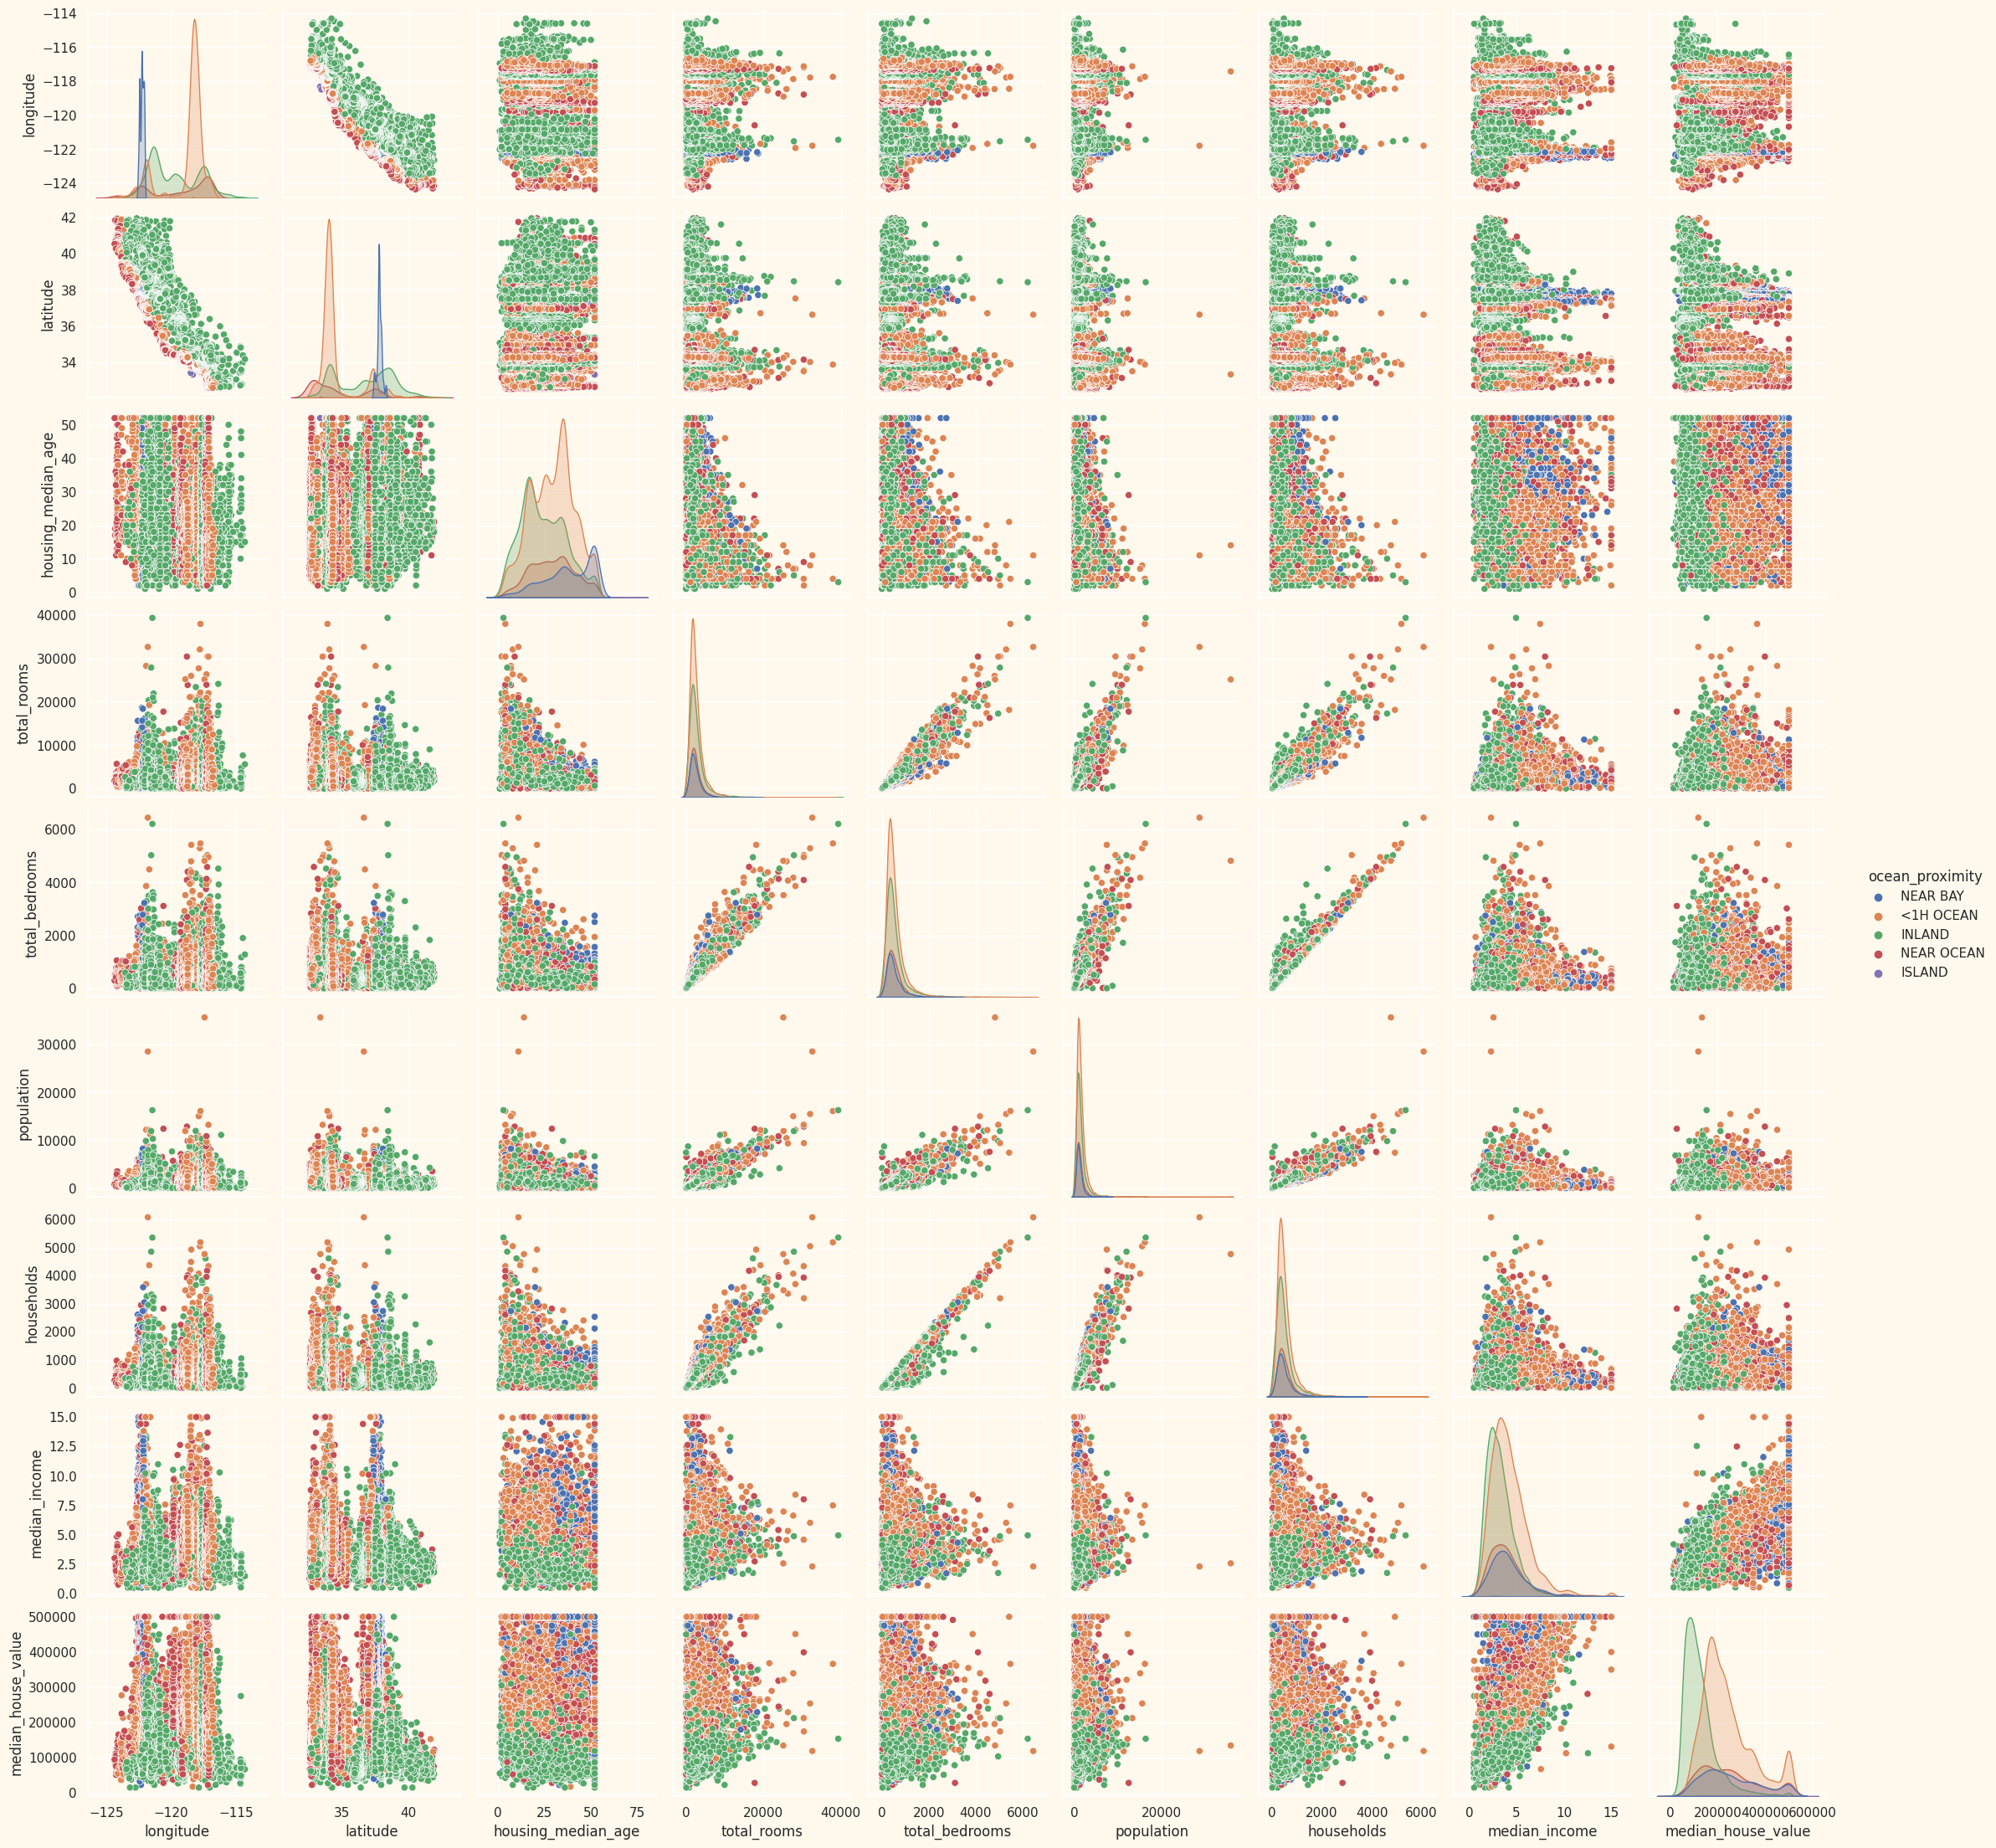

In [9]:
sns.pairplot(housing, hue="ocean_proximity")

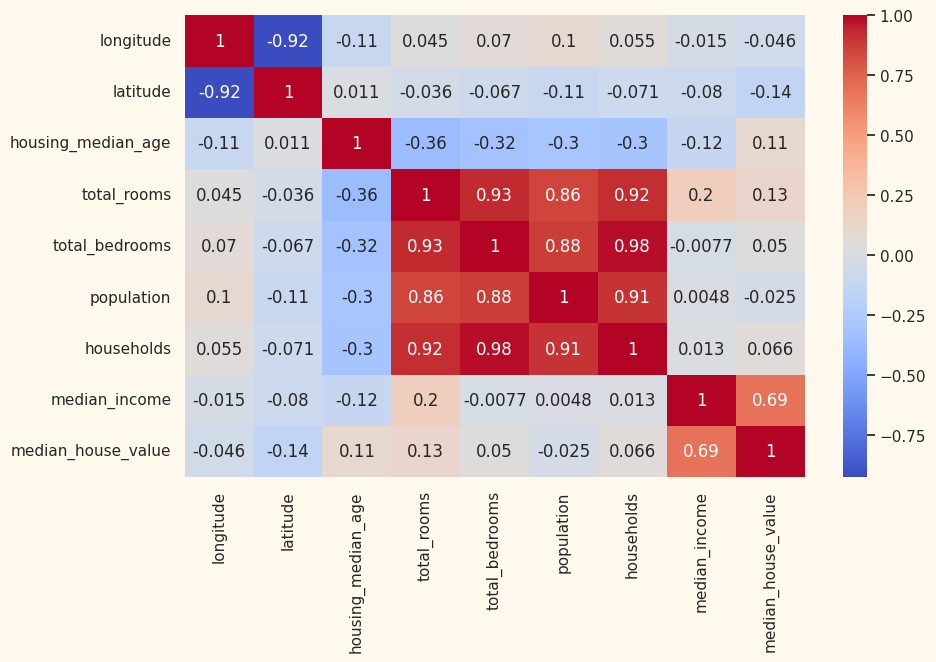

In [10]:
corr_matrix = housing.drop('ocean_proximity', axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

On the face of it, the following features seem to be decently correlated with the target - latitude.
Before going further in our analysis, let's create a train-test split stratified basis income.
Reason : We need to keep the distribution of income the same across the splits.

## Stratified Splitting

In [11]:
housing['income_cat_dummy'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing_train, housing_test = train_test_split(housing, test_size=0.2,
                                               stratify=housing['income_cat_dummy'], random_state=42)
print(f"Shapes of Train and Test Datasets are the following respectively : {housing_train.drop(columns=['income_cat_dummy'], axis=1).shape} & {housing_test.drop(columns=['income_cat_dummy'], axis=1).shape}")
labels = housing_train['median_house_value']
housing_train = housing_train.drop(['income_cat_dummy','median_house_value'], axis=1)
housing_test = housing_test.drop(['income_cat_dummy'], axis=1)

Shapes of Train and Test Datasets are the following respectively : (16512, 10) & (4128, 10)


<Axes: xlabel='income_cat_dummy'>

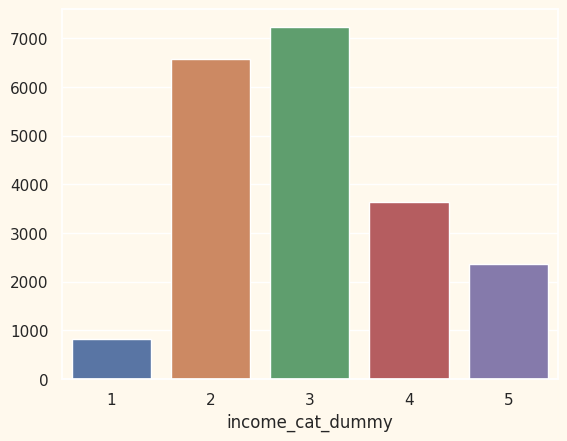

In [12]:
sns.barplot(x= housing['income_cat_dummy'].value_counts().index,y= housing['income_cat_dummy'].value_counts().values )
#housing = housing.drop(columns=['income_cat_dummy'], axis=1)

In [13]:
housing = housing.drop('income_cat_dummy', axis=1)
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

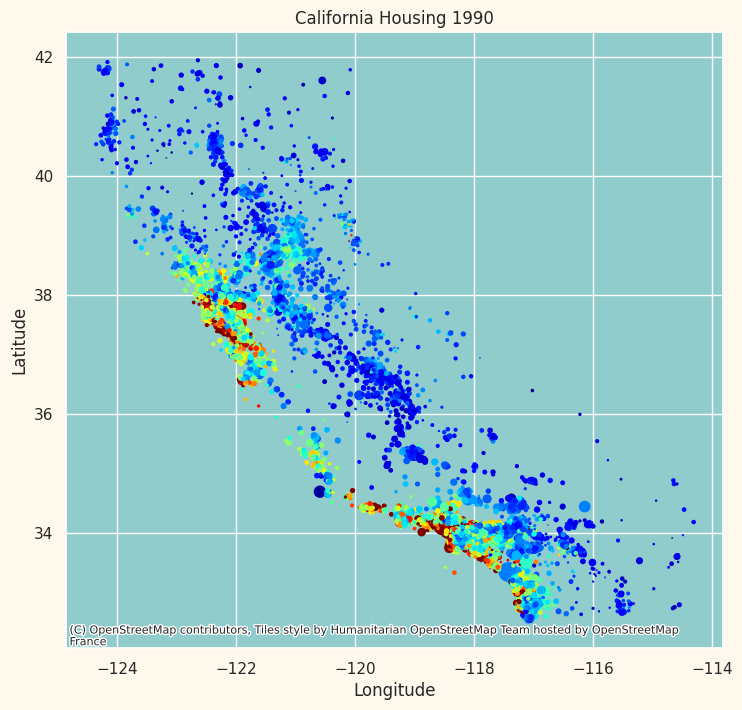

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(x=housing_train['longitude'], y=housing_train['latitude'], c=labels,
            s=housing_train['population']/200, cmap='jet')
plt.title('California Housing 1990')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ctx.add_basemap(plt.gca())


Now let's prepare the dataset for modeling using sklearn's beautiful feature : Pipelines()

## Pipeline Steps
1. Define new ratios which may help the regression task - bedroom/room, total room/households, population/household
2. Impute missing values with median for numerical features and with the most frequent class for categorical
3. One-hot encoding for categories.
4. RBF Similarity values with n_clusters found using K means.
5. Standard scaling the data 
6. log-transformations for right-skewed columns as noticed in the kdeplots above.

### Similarity-Cluster Custom Pipeline

In [15]:
class SimilarityCluster(TransformerMixin, BaseEstimator):
    
    def __init__(self, n_clusters=10, gamma=1.):
        self.n_clusters = n_clusters
        self.gamma = gamma
        
    def fit(self, X, y=None, sample_weight=None):
        self.k_means_ = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.k_means_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, Y=self.k_means_.cluster_centers_, gamma=self.gamma)
    
    def get_cluster_centers(self):
        return self.k_means_.cluster_centers_
    
    def get_cluster_labels(self):
        return self.k_means_.labels_
    
    def get_feature_names_out(self, names=None):
        return [f"cluster {i} similarity" for i in range(self.n_clusters)]
        

In [16]:
def plot_cluster_info(clusterInstance):
    cluster_sim = clusterInstance
    cluster_centers = cluster_sim.get_cluster_centers()
    cluster_labels = cluster_sim.get_cluster_labels()
    figure, axs = plt.subplots(1,2, figsize=(12,7))
    axs=axs.flatten()
    #plt.figure(figsize=(12,5))
    axs[0].scatter(x=housing_train['longitude'], y=housing_train['latitude'],
                s=housing_train['population']/200, alpha=0.7, c=cluster_sim_tr.mean(axis=1), cmap='jet')

    # Customize cluster centers
    axs[0].scatter(y=pd.DataFrame(cluster_centers).iloc[0:, 0], x=pd.DataFrame(cluster_centers).iloc[0:, 1],
                s=300, marker='x', linewidths=2, color='black')

    # Add labels, title, and colorbar
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].set_title('California Housing : Districts\' Cluster Similarity')
    
    axs[1].scatter(x=housing_train['longitude'], y=housing_train['latitude'],
                s=housing_train['population']/200, alpha=0.7, c=pd.DataFrame(cluster_labels), cmap='viridis')

    # Customize cluster centers
    axs[1].scatter(y=pd.DataFrame(cluster_centers).iloc[0:, 0], x=pd.DataFrame(cluster_centers).iloc[0:, 1],
                s=300, marker='x', linewidths=2, color='black')

    # Add labels, title, and colorbar
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel('Latitude')
    axs[1].set_title('California Housing : Clusters')
    plt.show()

Let's overlap and plot these clusters 

In [17]:
cluster_sim = SimilarityCluster(n_clusters=20,gamma=1.)
cluster_sim_tr = cluster_sim.fit_transform(housing_train[['latitude','longitude']], sample_weight=labels)
print(f"Shape of the new features generated : {cluster_sim_tr.shape} and columns names are : {cluster_sim.get_feature_names_out()}")

Shape of the new features generated : (16512, 20) and columns names are : ['cluster 0 similarity', 'cluster 1 similarity', 'cluster 2 similarity', 'cluster 3 similarity', 'cluster 4 similarity', 'cluster 5 similarity', 'cluster 6 similarity', 'cluster 7 similarity', 'cluster 8 similarity', 'cluster 9 similarity', 'cluster 10 similarity', 'cluster 11 similarity', 'cluster 12 similarity', 'cluster 13 similarity', 'cluster 14 similarity', 'cluster 15 similarity', 'cluster 16 similarity', 'cluster 17 similarity', 'cluster 18 similarity', 'cluster 19 similarity']


## Plot : Housing Clusters and Similarity

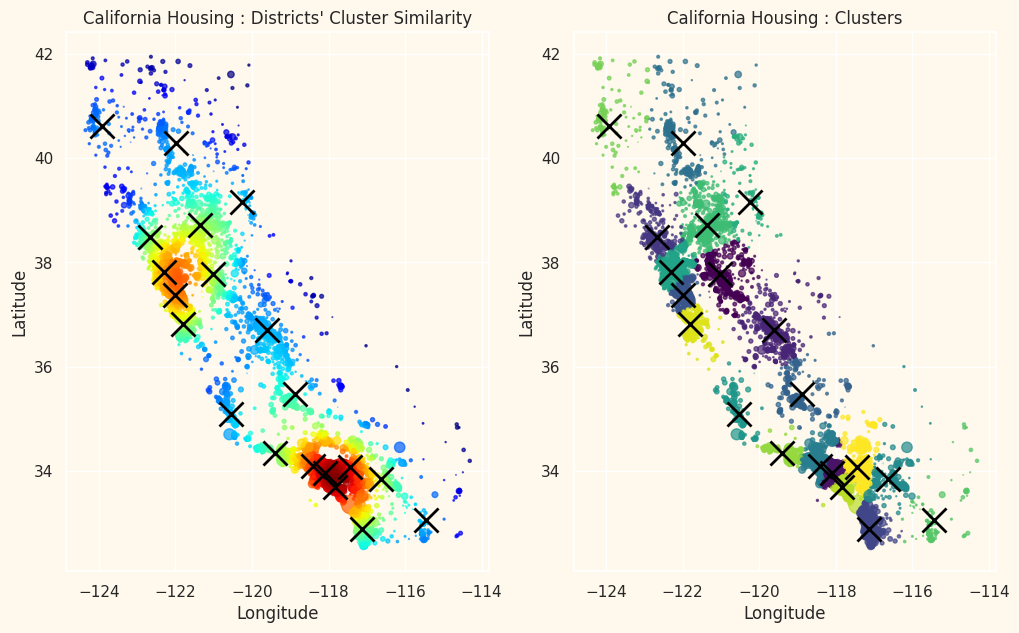

In [18]:
plot_cluster_info(cluster_sim)

Let's now continue with the pipeline

1. Define new ratios which may help the regression task - bedroom/room, total room/households, population/household
2. Impute missing values with median for numerical features and with the most frequent class for categorical
3. One-hot encoding for categories.
4. RBF Similarity values with n_clusters found using K means.
5. Standard scaling the data 
6. log-transformations for right-skewed columns as noticed in the kdeplots above.

In [19]:
# Initiating Pipeline chunks

def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_names(functionTransformer,feature_names_in):
    return ['ratio']
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out = 'one-to-one'),
    StandardScaler())

ratio_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(column_ratio, feature_names_out=ratio_names),
    StandardScaler())

district_similarity = SimilarityCluster(n_clusters=10, gamma=1.)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

default_cat_pipelint = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

In [20]:
# Construct the final pre-processing pipeline
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline, ['total_bedrooms','total_rooms']),
    ("rooms_per_household", ratio_pipeline, ['total_rooms','households']),
    ("occupants_per_household", ratio_pipeline, ['population','households']),
    ("log", log_pipeline, ['total_rooms','total_bedrooms','population','households','median_income']),
    ("geo", district_similarity, ['latitude','longitude']),
    ("cat", default_cat_pipelint, make_column_selector(dtype_include=object))],
remainder = default_num_pipeline)
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_names at 0x7c7367701c60>,
                                                                      func=<function column_rati...
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('geo', SimilarityCluster(),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c7367866da0>)])

In [21]:
housing_train_pp = preprocessing.fit_transform(housing_train)
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_household__ratio',
       'occupants_per_household__ratio', 'log__total_rooms',
       'log__total_bedrooms', 'log__population', 'log__households',
       'log__median_income', 'geo__cluster 0 similarity',
       'geo__cluster 1 similarity', 'geo__cluster 2 similarity',
       'geo__cluster 3 similarity', 'geo__cluster 4 similarity',
       'geo__cluster 5 similarity', 'geo__cluster 6 similarity',
       'geo__cluster 7 similarity', 'geo__cluster 8 similarity',
       'geo__cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

Let's fit models now, and evaluate the same

## Linear Regression

In [22]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing_train, labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_names at 0x7c...
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('geo', SimilarityCluster(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c7367866da0>)])),
                ('linearregression', LinearRegression())])

In [23]:
lin_reg_rmse = mean_squared_error(labels, lin_reg.predict(housing_train),squared=False)
print(f"RMSE for a simple linear regression model is : {lin_reg_rmse}")

RMSE for a simple linear regression model is : 69206.78692511107


## Decision Tree

In [24]:
dtree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
dtree_reg.fit(housing_train, labels)
dtree_reg_rmse = mean_squared_error(labels, dtree_reg.predict(housing_train), squared=False)
print(f"RMSE for a D tree model is : {dtree_reg_rmse}")

RMSE for a D tree model is : 0.0


Let's 10-fold cross-validate the tree.
We will use sklearn's cross_val_score

In [25]:
d_tree_cvarray = -cross_val_score(dtree_reg, housing_train,labels, cv=10, scoring='neg_root_mean_squared_error' )

In [26]:
print(pd.Series(d_tree_cvarray).describe())

count       10.000000
mean     67730.246816
std       2921.831054
min      63082.286675
25%      65439.015368
50%      67743.381636
75%      69507.860649
max      72802.304476
dtype: float64


The tree isn't performing well when cross validated. The rmse is similar to linear model and the std is also quite high.
The tree is fully overfitting. To overcome this we have an ensemble model of tree - RandomForests

## Random Forest

In [27]:
rforest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(n_estimators=100, random_state=42))
 
rforest_reg_cvarray = -cross_val_score(rforest_reg,housing_train,labels, cv=10, scoring='neg_root_mean_squared_error')

In [28]:
print(pd.Series(rforest_reg_cvarray).describe())

count       10.000000
mean     47310.025275
std       2499.955925
min      43675.024755
25%      45239.634669
50%      47299.870905
75%      49024.706055
max      51235.012212
dtype: float64


## Grid Search CV

In [29]:
full_pipeline = Pipeline([
 ("preprocessing", preprocessing),
 ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
 {'preprocessing__geo__n_clusters': [5, 8, 10],
 'random_forest__max_features': [4, 6, 8]},
 {'preprocessing__geo__n_clusters': [10, 15],
 'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')

grid_search.fit(housing_train,labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7c7367866da0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [30]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [31]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.325344      0.323861         0.182192        0.002213   
1        7.014501      0.421118         0.186592        0.006125   
2        8.029970      0.204667         0.189367        0.003832   
3        5.496145      0.426082         0.185452        0.002627   
4        7.044981      0.335747         0.182426        0.001148   
5        8.240645      0.132042         0.187131        0.007795   
6        5.444938      0.182644         0.194901        0.016681   
7        7.055602      0.277654         0.192300        0.008687   
8        8.273200      0.044373         0.182589        0.002556   
9        6.753240      0.140073         0.183698        0.001181   
10       8.561257      0.434156         0.185037        0.002937   
11       9.831985      0.110719         0.197512        0.007525   
12       7.090322      0.023593         0.188601        0.003115   
13       8.609485      0.077339         0.190895        0.007536   
14      10.199354      0.206229         0.186115        0.008575   

   param_preprocessing__geo__n_clusters param_random_forest__max_features  \
0                                     5                                 4   
1                                     5                                 6   
2                                     5                                 8   
3                                     8                                 4   
4                                     8                                 6   
5                                     8                                 8   
6                                    10                                 4   
7                                    10                                 6   
8                                    10                                 8   
9                                    10                                 6   
10                                   10                                 8   
11                                   10                                10   
12                                   15                                 6   
13                                   15                                 8   
14                                   15                                10   

                                               params  split0_test_score  \
0   {'preprocessing__geo__n_clusters': 5, 'random_...      -47717.095412   
1   {'preprocessing__geo__n_clusters': 5, 'random_...      -47231.793781   
2   {'preprocessing__geo__n_clusters': 5, 'random_...      -47396.978149   
3   {'preprocessing__geo__n_clusters': 8, 'random_...      -44962.524368   
4   {'preprocessing__geo__n_clusters': 8, 'random_...      -45000.437393   
5   {'preprocessing__geo__n_clusters': 8, 'random_...      -45507.156605   
6   {'preprocessing__geo__n_clusters': 10, 'random...      -44373.568790   
7   {'preprocessing__geo__n_clusters': 10, 'random...      -44420.522047   
8   {'preprocessing__geo__n_clusters': 10, 'random...      -44663.126411   
9   {'preprocessing__geo__n_clusters': 10, 'random...      -44420.522047   
10  {'preprocessing__geo__n_clusters': 10, 'random...      -44663.126411   
11  {'preprocessing__geo__n_clusters': 10, 'random...      -45303.588798   
12  {'preprocessing__geo__n_clusters': 15, 'random...      -42914.115809   
13  {'preprocessing__geo__n_clusters': 15, 'random...      -43591.745072   
14  {'preprocessing__geo__n_clusters': 15, 'random...      -43969.630780   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0       -47897.837989      -49112.595860    -48242.509754      619.652776   
1       -47580.431624      -48946.814966    -47919.680123      740.108809   
2       -47839.364970      -49378.973477    -48205.105532      849.470811   
3       -45784.114357      -46749.930164    -45832.189630      730.496769   
4       -45823.639545      -46717.177655    -45847.084864      701.052325   
5  